<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Base-case" data-toc-modified-id="Base-case-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Base case</a></span></li><li><span><a href="#Base-model" data-toc-modified-id="Base-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Base model</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature engineering</a></span></li><li><span><a href="#Target-Mean-Encoding" data-toc-modified-id="Target-Mean-Encoding-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Target Mean Encoding</a></span></li><li><span><a href="#Buysharespct-vs-sellshrspct-12m-Example" data-toc-modified-id="Buysharespct-vs-sellshrspct-12m-Example-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Buysharespct vs sellshrspct 12m Example</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Clustering</a></span></li></ul></div>

In [1]:
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import log_loss
pd.options.display.max_rows=300

params = {
    "max_depth":-1,
    "learning_rate":.01,
    "n_estimators":1000,
    "objective":"binary",
    "device":"gpu",
    "random_state":42
}

lgb = LGBMClassifier(**params)

train_ = pd.read_pickle("./train_115.pkl")
x = train_.date.dt.year
train = train_[x<=2012]
test = train_[((2012<x)&(x<=2015))]

y_train = train["target"]
X_train = train.drop("target",1)
y_test = test["target"]
X_test = test.drop("target",1)

train.columns

Index(['date', 'idx', 'f__buytransactions_1m', 'f__selltransactions_1m',
       'f__buyshares_1m', 'f__sellshares_1m', 'f__buysharespctsharesout_1m',
       'f__sellsharespctsharesout_1m', 'f__uniquebuyers_1m',
       'f__uniquesellers_1m', 'f__buytransactions_3m',
       'f__selltransactions_3m', 'f__buyshares_3m', 'f__sellshares_3m',
       'f__buysharespctsharesout_3m', 'f__sellsharespctsharesout_3m',
       'f__uniquebuyers_3m', 'f__uniquesellers_3m', 'f__buytransactions_6m',
       'f__selltransactions_6m', 'f__buyshares_6m', 'f__sellshares_6m',
       'f__buysharespctsharesout_6m', 'f__sellsharespctsharesout_6m',
       'f__uniquebuyers_6m', 'f__uniquesellers_6m', 'f__buytransactions_12m',
       'f__selltransactions_12m', 'f__buyshares_12m', 'f__sellshares_12m',
       'f__buysharespctsharesout_12m', 'f__sellsharespctsharesout_12m',
       'f__uniquebuyers_12m', 'f__uniquesellers_12m', 'target', 'cnt'],
      dtype='object')

# Base case

In [2]:
log_loss(y_train,np.ones_like(y_train)/2)

0.693147180559946

# Base model

In [3]:
num_cols = X_train.select_dtypes(include="number").columns
lgb.fit(X_train[num_cols], y_train)
log_loss(y_train, lgb.predict_proba(X_train[num_cols]))
#0.6458755547393696
#0.6458558605997866
#0.6459021807097592

0.6458408110348537

# Feature engineering

1. Dates  

2. buytrans minus selltrans:
    - 1M
    - 3M
    - 6M
    - 12M

3. buyshares plus sellshares (**sellshares are negative!!!**):
    - 1M
    - 3M
    - 6M
    - 12M

4. uniqubuyers minus uniquesellers:
    - 1M
    - 3M
    - 6M
    - 12M

5. buysharespctsharesout plus sellsharespctsharesout (**sellshares are negative!!!**):
    - 1M
    - 3M
    - 6M
    - 12M

6. buytrans 1m minus:
    - 3M
    - 6M
    - 12M

7. selltrans 1m minus:
    - 3M
    - 6M
    - 12M

8. buyshares 1M minus:
    - 3M
    - 6M
    - 12M

9. sellshares 1M minus:
    - 3M
    - 6M
    - 12M

10. unique buyers 1M minus:
    - 3M
    - 6M
    - 12M

12. unique sellers 1M minus:
    - 3M
    - 6M
    - 12M

13. buysharespctsharesout 1M minus:
    - 3M
    - 6M
    - 12M

14. sellsharespctsharesout 1M minus:
    - 3M
    - 6M
    - 12M

In [4]:
def add_date(df):
    df["year"] = df["date"].dt.year.astype("int32")
    df["month"] = df["date"].dt.month.astype("int32")
    df["quarter"] = df["date"].dt.quarter.astype("int32")
    df["week"] = df["date"].dt.isocalendar().week.astype("int32")
    df["day"] = df["date"].dt.dayofyear.astype("int32")
    df.drop("date", axis=1, inplace=True)
    df["btrs_strs_1m"] = df["f__buytransactions_1m"] - df["f__selltransactions_1m"]
    df["btrs_strs_3m"] = df["f__buytransactions_3m"] - df["f__selltransactions_3m"]
    df["btrs_strs_6m"] = df["f__buytransactions_6m"] - df["f__selltransactions_6m"]
    df["btrs_strs_12m"] = df["f__buytransactions_12m"] - df["f__selltransactions_12m"]
    df["bshrs_sshrs_1m"] = df["f__buyshares_1m"] - df["f__sellshares_1m"]
    df["bshrs_sshrs_3m"] = df["f__buyshares_3m"] - df["f__sellshares_3m"]
    df["bshrs_sshrs_6m"] = df["f__buyshares_6m"] - df["f__sellshares_6m"]
    df["bshrs_sshrs_12m"] = df["f__buyshares_12m"] - df["f__sellshares_12m"]
#############45
    df["unqb_unqs_1m"] = df["f__uniquebuyers_1m"] - df["f__uniquesellers_1m"]
    df["unqb_unqs_3m"] = df["f__uniquebuyers_3m"] - df["f__uniquesellers_3m"]
    df["unqb_unqs_6m"] = df["f__uniquebuyers_6m"] - df["f__uniquesellers_6m"]
    df["unqb_unqs_12m"] = df["f__uniquebuyers_12m"] - df["f__uniquesellers_12m"]
    df["bpct_spct_1m"] = (
        df["f__buysharespctsharesout_1m"] + df["f__sellsharespctsharesout_1m"]
    )
    df["bpct_spct_3m"] = (
        df["f__buysharespctsharesout_3m"] + df["f__sellsharespctsharesout_3m"]
    )
    df["bpct_spct_6m"] = (
        df["f__buysharespctsharesout_6m"] + df["f__sellsharespctsharesout_6m"]
    )
    df["bpct_spct_12m"] = (
        df["f__buysharespctsharesout_12m"] + df["f__sellsharespctsharesout_12m"]
    )
#############
    df['btrs1m_btrs3m'] = df["f__buytransactions_1m"] - df["f__buytransactions_3m"]
    df['btrs1m_btrs6m'] = df["f__buytransactions_1m"] - df["f__buytransactions_6m"]
    df['btrs1m_btrs12m'] = df["f__buytransactions_1m"] - df["f__buytransactions_12m"]
    df['strs1m_strs3m'] = df["f__selltransactions_1m"] - df["f__selltransactions_3m"]
    df['strs1m_strs6m'] = df["f__selltransactions_1m"] - df["f__selltransactions_6m"]
#############60
    df['strs1m_strs12m'] = df["f__selltransactions_1m"] - df["f__selltransactions_12m"]
    df['bsrs1m_bshrs3m'] = df["f__buyshares_1m"] - df["f__buyshares_3m"]
    df['bsrs1m_bshrs6m'] = df["f__buyshares_1m"] - df["f__buyshares_6m"]
    df['bsrs1m_bshrs12m'] = df["f__buyshares_1m"] - df["f__buyshares_12m"]
    df['sshrs1m_sshrs3m'] = df["f__sellshares_1m"] - df["f__sellshares_3m"]
    df['sshrs1m_sshrs6m'] = df["f__sellshares_1m"] - df["f__sellshares_6m"]
    df['sshrs1m_sshrs12m'] = df["f__sellshares_1m"] - df["f__sellshares_12m"]
    df['unqb1m_unqb3m'] = df['f__uniquebuyers_1m'] - df['f__uniquebuyers_3m'] 
    df['unqb1m_unqb6m'] = df['f__uniquebuyers_1m'] - df['f__uniquebuyers_6m']
    df['unqb1m_unqb12m'] = df['f__uniquebuyers_1m'] - df['f__uniquebuyers_12m'] 
    df['unqs1m_unqs3m'] = df["f__uniquesellers_1m"] - df["f__uniquesellers_3m"]
    df['unqs1m_unqs6m'] = df["f__uniquesellers_1m"] - df["f__uniquesellers_6m"]
    df['unqs1m_unqs12m'] = df["f__uniquesellers_1m"] - df["f__uniquesellers_12m"]
    df["bpct1m_bpct3m"] = df["f__buysharespctsharesout_1m"] - df["f__buysharespctsharesout_3m"]
    df["bpct1m_bpct6m"] = df["f__buysharespctsharesout_1m"] - df["f__buysharespctsharesout_6m"]
    df["bpct1m_bpct12m"] = df["f__buysharespctsharesout_1m"] - df["f__buysharespctsharesout_12m"]
    df["spct1m_spct3m"] = df["f__sellsharespctsharesout_1m"] - df["f__sellsharespctsharesout_3m"]
    df["spct1m_spct6m"] = df["f__sellsharespctsharesout_1m"] - df["f__sellsharespctsharesout_6m"]
    df["spct1m_spct12m"] = df["f__sellsharespctsharesout_1m"] - df["f__sellsharespctsharesout_12m"]

add_date(X_train)
add_date(X_test)

### Choose num of features: 45,55,60
# num_cols = X_train.select_dtypes(include="number").columns[:45]

# LightGBM employes a peculiar [strategy](https://datascience.stackexchange.com/questions/65956/how-do-gbm-algorithms-handle-missing-data)  to handle missing values. Imputing missing values will make it worse:

lgb.fit(X_train, y_train)
log_loss(y_train, lgb.predict_proba(X_train))
# 0.6445713097267892
# 0.6446687021689067
# 0.6445713109503719
# 0.6447565903932139
# 0.6446061969954247

0.6449596185491572

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


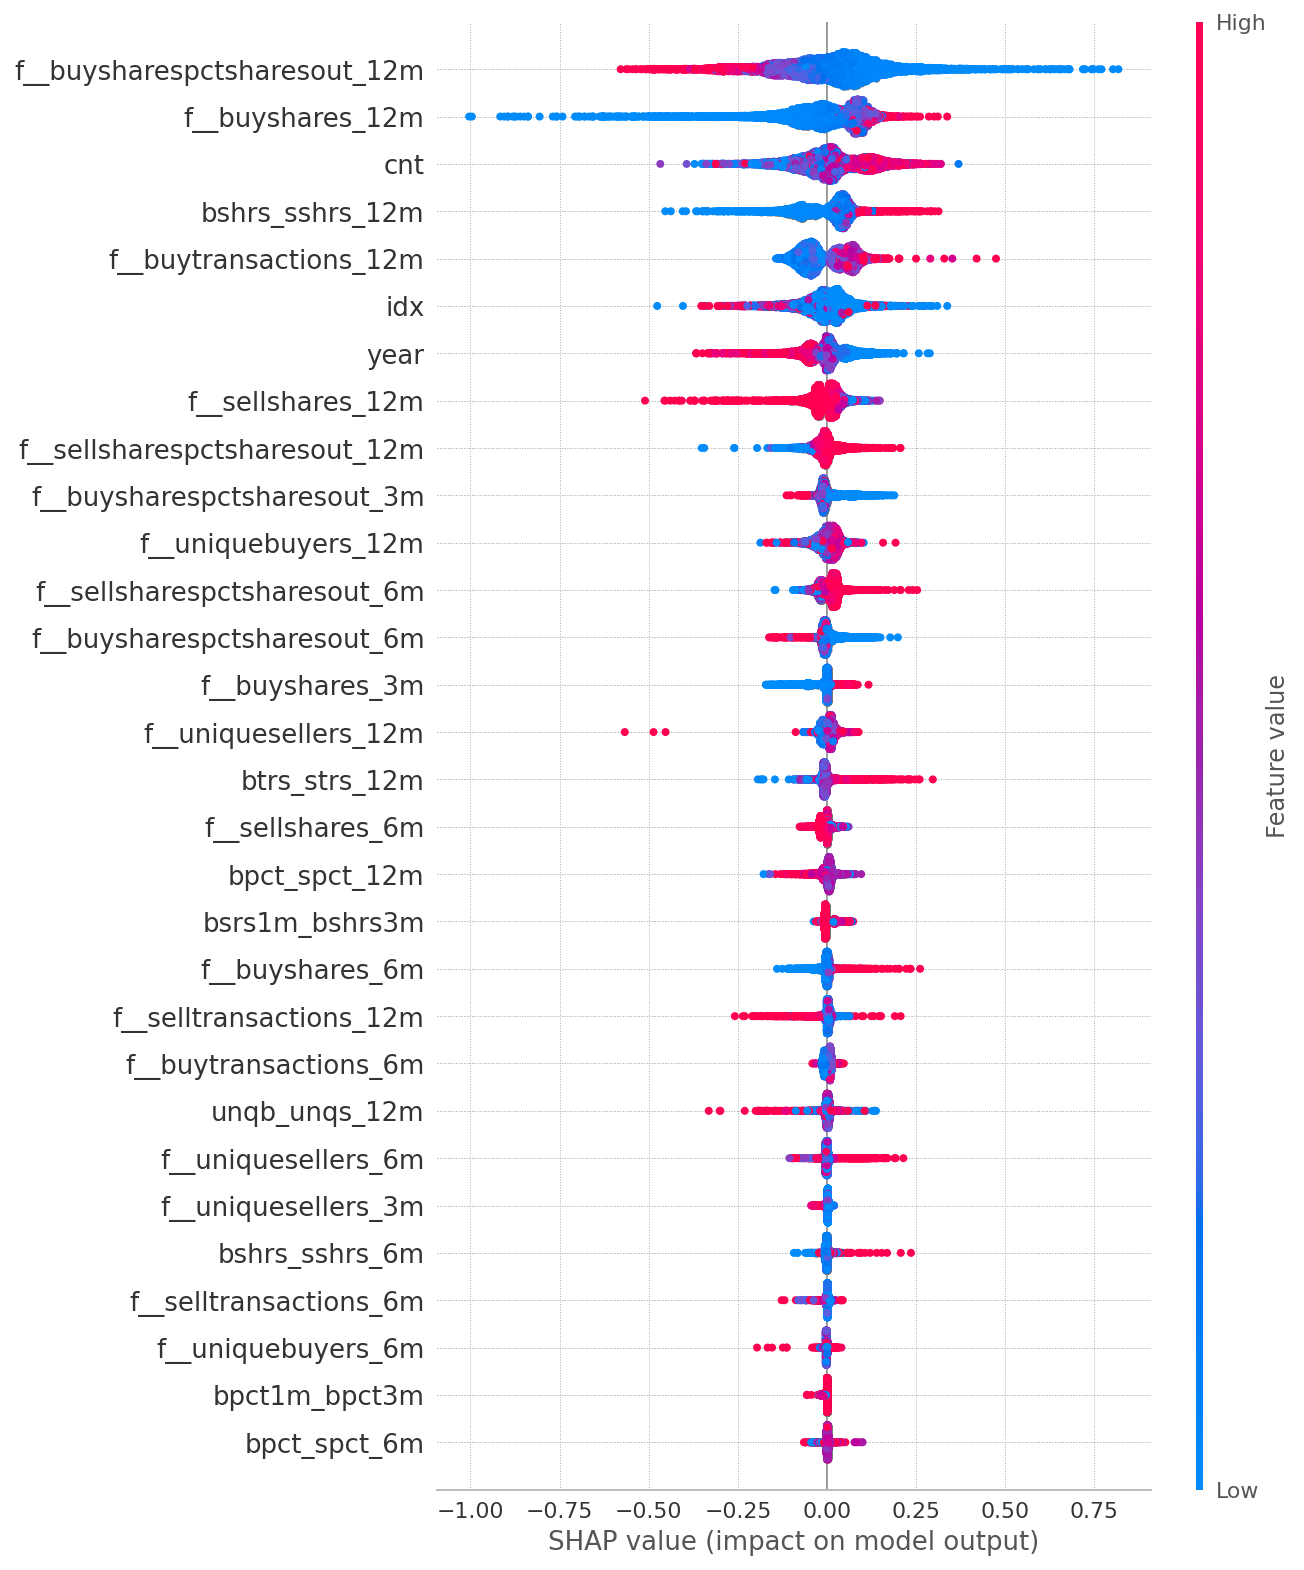

In [5]:
import shap
x = X_train.sample(frac=.01)
from shap import TreeExplainer, summary_plot
explainer = TreeExplainer(lgb)
sv = explainer.shap_values(x)
summary_plot(sv[1],x, max_display=30)

# Target Mean Encoding

In [6]:
def enc(arr, period, shift=156):
    return arr[-shift - period : -shift].mean()

for period in [4,12,24,52]:
    name = "tme"+ str(period)
    X_train[name] = (
        X_train.
        assign(target=y_train.values).
        groupby("idx").
        expanding().
        agg({"target": lambda arr: enc(arr, period)}).
        fillna(0).
        values
    )
X_train.columns

Index(['idx', 'f__buytransactions_1m', 'f__selltransactions_1m',
       'f__buyshares_1m', 'f__sellshares_1m', 'f__buysharespctsharesout_1m',
       'f__sellsharespctsharesout_1m', 'f__uniquebuyers_1m',
       'f__uniquesellers_1m', 'f__buytransactions_3m',
       'f__selltransactions_3m', 'f__buyshares_3m', 'f__sellshares_3m',
       'f__buysharespctsharesout_3m', 'f__sellsharespctsharesout_3m',
       'f__uniquebuyers_3m', 'f__uniquesellers_3m', 'f__buytransactions_6m',
       'f__selltransactions_6m', 'f__buyshares_6m', 'f__sellshares_6m',
       'f__buysharespctsharesout_6m', 'f__sellsharespctsharesout_6m',
       'f__uniquebuyers_6m', 'f__uniquesellers_6m', 'f__buytransactions_12m',
       'f__selltransactions_12m', 'f__buyshares_12m', 'f__sellshares_12m',
       'f__buysharespctsharesout_12m', 'f__sellsharespctsharesout_12m',
       'f__uniquebuyers_12m', 'f__uniquesellers_12m', 'cnt', 'year', 'month',
       'quarter', 'week', 'day', 'btrs_strs_1m', 'btrs_strs_3m',
       'btrs_

In [7]:
lgb.fit(X_train,y_train)
log_loss(y_train, lgb.predict_proba(X_train))
#0.6409620312279963
#0.6409065699506119
#0.6409065656153017

0.6436428038924967

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


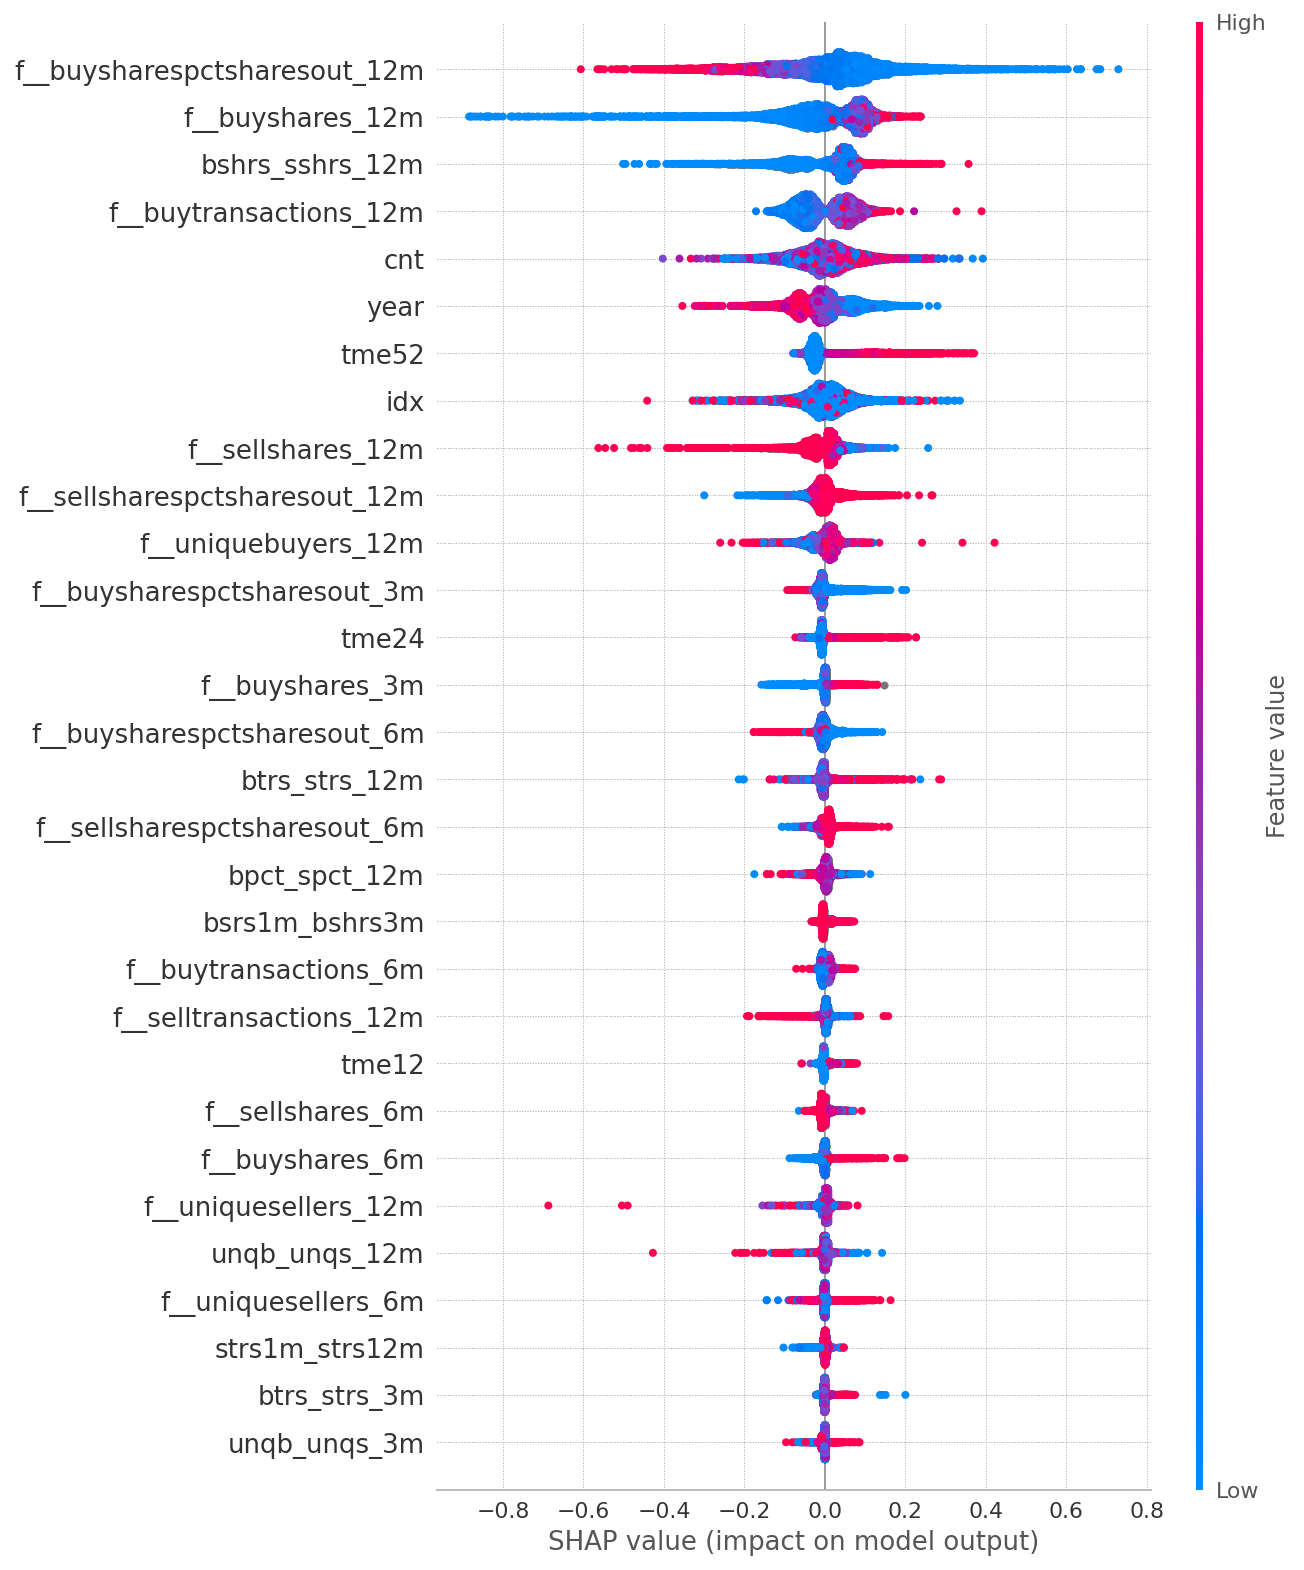

In [8]:
from shap import TreeExplainer
x = X_train.sample(frac=.01)
explainer = TreeExplainer(lgb)
sv = explainer.shap_values(x)
summary_plot(sv[1],x, max_display=30)

# Buysharespct vs sellshrspct 12m Example

In [9]:
bspct_log_12 = (
    X_train[["idx", "f__buysharespctsharesout_12m", 'f__sellsharespctsharesout_12m']]
    .groupby("idx")
    .mean()
    .fillna(0)
    .apply(lambda x: np.log(x+1e-6) if all(x>=0) else -np.log(-x+1e-6))
)
bspct_log_12.head()

,f__buysharespctsharesout_12m,f__sellsharespctsharesout_12m
idx,,
2585893,-3.647662,4.844022
2585895,-4.420927,5.113204
2585941,-3.784433,3.205035
2585957,-4.557597,7.403442
2585966,-4.848724,3.379951


Let's determine optimal number of clusters:

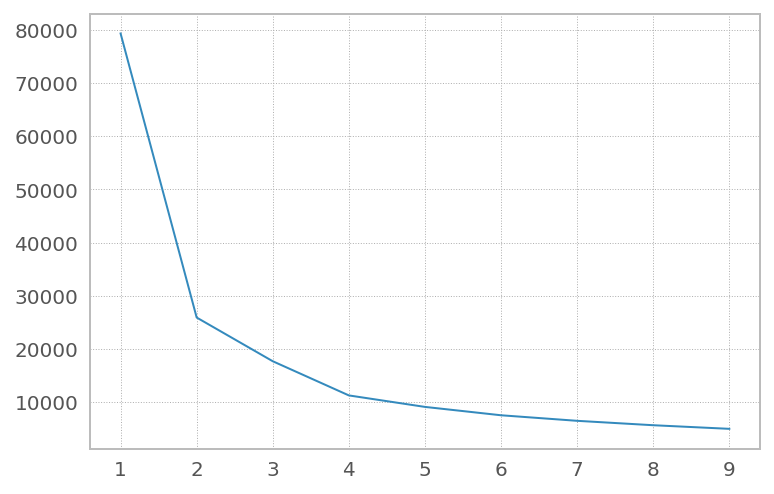

In [10]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(bspct_log_12)
    sse[k] = kmeans.inertia_ 
plt.plot(*zip(*sse.items()));

In [11]:
C = KMeans(10, random_state=42).fit_predict(bspct_log_12)
Counter(C)

Counter({5: 800,
         0: 1071,
         4: 516,
         9: 456,
         8: 282,
         3: 620,
         6: 196,
         7: 35,
         2: 139,
         1: 333})

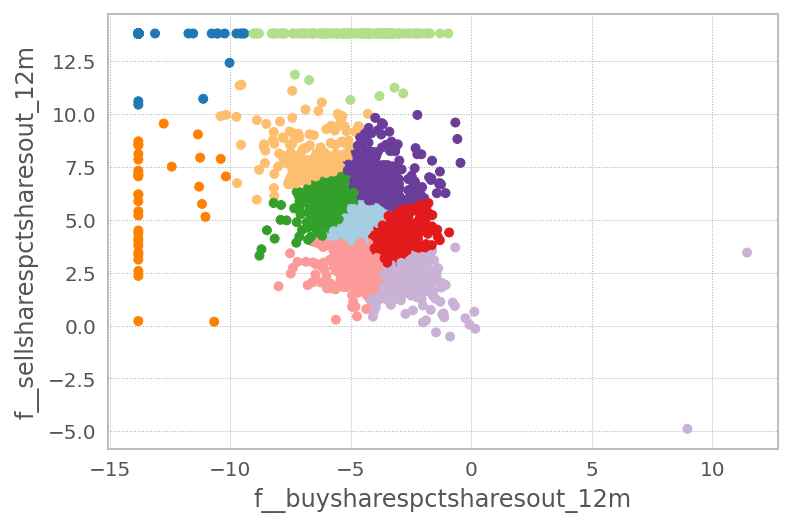

In [12]:
from matplotlib.cm import Paired
bspct_log_12.plot.scatter(
    x="f__buysharespctsharesout_12m",
    y="f__sellsharespctsharesout_12m",
    c=Paired(C),
);

# Clustering

In [13]:
col_list = ['f__buytransactions_1m', 'f__selltransactions_1m',
       'f__buyshares_1m', 'f__sellshares_1m', 'f__buysharespctsharesout_1m',
       'f__sellsharespctsharesout_1m', 'f__uniquebuyers_1m',
       'f__uniquesellers_1m', 'f__buytransactions_3m',
       'f__selltransactions_3m', 'f__buyshares_3m', 'f__sellshares_3m',
       'f__buysharespctsharesout_3m', 'f__sellsharespctsharesout_3m',
       'f__uniquebuyers_3m', 'f__uniquesellers_3m', 'f__buytransactions_6m',
       'f__selltransactions_6m', 'f__buyshares_6m', 'f__sellshares_6m',
       'f__buysharespctsharesout_6m', 'f__sellsharespctsharesout_6m',
       'f__uniquebuyers_6m', 'f__uniquesellers_6m', 'f__buytransactions_12m',
       'f__selltransactions_12m', 'f__buyshares_12m', 'f__sellshares_12m',
       'f__buysharespctsharesout_12m', 'f__sellsharespctsharesout_12m',
       'f__uniquebuyers_12m', 'f__uniquesellers_12m']

In [14]:
from itertools import combinations as comb
from sklearn.cluster import KMeans

km = KMeans(10, random_state=42)


def log_trans(pair_df):
    """
    Accepts a 3 column df
    Returns a log-transfomed df of means of columns
    Dimensions are reduced to (num_companies × 2)
    """
    return (
        pair_df.groupby("idx")
        .mean()
        .fillna(0)
        .apply(lambda x: np.log(x + 1e-6) if all(x >= 0) else -np.log(-x + 1e-6))
    )


def cluster_collist(df, col_list):
    """
    Arguments:
        df
        col_list: list of colmns to be clustered by pair combinations
    Returns tuple of:
        1. clusters concatenated to original df
        dimension of original is preserved
        2. cluster mappings to be applied to test
    """
    for pair in tqdm(list(comb(col_list, 2))):
#         print(pair)
        sample = df[["idx", *pair]]
        try:
            log_sample = log_trans(sample)
            C = km.fit_predict(log_sample)
            out = pd.DataFrame({"cl": C}, index=log_sample.index)
        except:
            print("Failed to log-transform pair:", pair)
            out = pd.DataFrame({"cl": 99}, index=log_sample.index)
        df = df.merge(
            out, left_on="idx", right_on=out.index, suffixes=("", "_" + "_".join(pair))
        )
    return df, out

In [15]:
X_train.columns

Index(['idx', 'f__buytransactions_1m', 'f__selltransactions_1m',
       'f__buyshares_1m', 'f__sellshares_1m', 'f__buysharespctsharesout_1m',
       'f__sellsharespctsharesout_1m', 'f__uniquebuyers_1m',
       'f__uniquesellers_1m', 'f__buytransactions_3m',
       'f__selltransactions_3m', 'f__buyshares_3m', 'f__sellshares_3m',
       'f__buysharespctsharesout_3m', 'f__sellsharespctsharesout_3m',
       'f__uniquebuyers_3m', 'f__uniquesellers_3m', 'f__buytransactions_6m',
       'f__selltransactions_6m', 'f__buyshares_6m', 'f__sellshares_6m',
       'f__buysharespctsharesout_6m', 'f__sellsharespctsharesout_6m',
       'f__uniquebuyers_6m', 'f__uniquesellers_6m', 'f__buytransactions_12m',
       'f__selltransactions_12m', 'f__buyshares_12m', 'f__sellshares_12m',
       'f__buysharespctsharesout_12m', 'f__sellsharespctsharesout_12m',
       'f__uniquebuyers_12m', 'f__uniquesellers_12m', 'cnt', 'year', 'month',
       'quarter', 'week', 'day', 'btrs_strs_1m', 'btrs_strs_3m',
       'btrs_

In [16]:
X, cluster_map = cluster_collist(X_train, col_list)

  0%|          | 0/496 [00:00<?, ?it/s]

In [17]:
lgb.fit(X,y_train)
log_loss(y_train, lgb.predict_proba(X))

0.6115350042926229

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


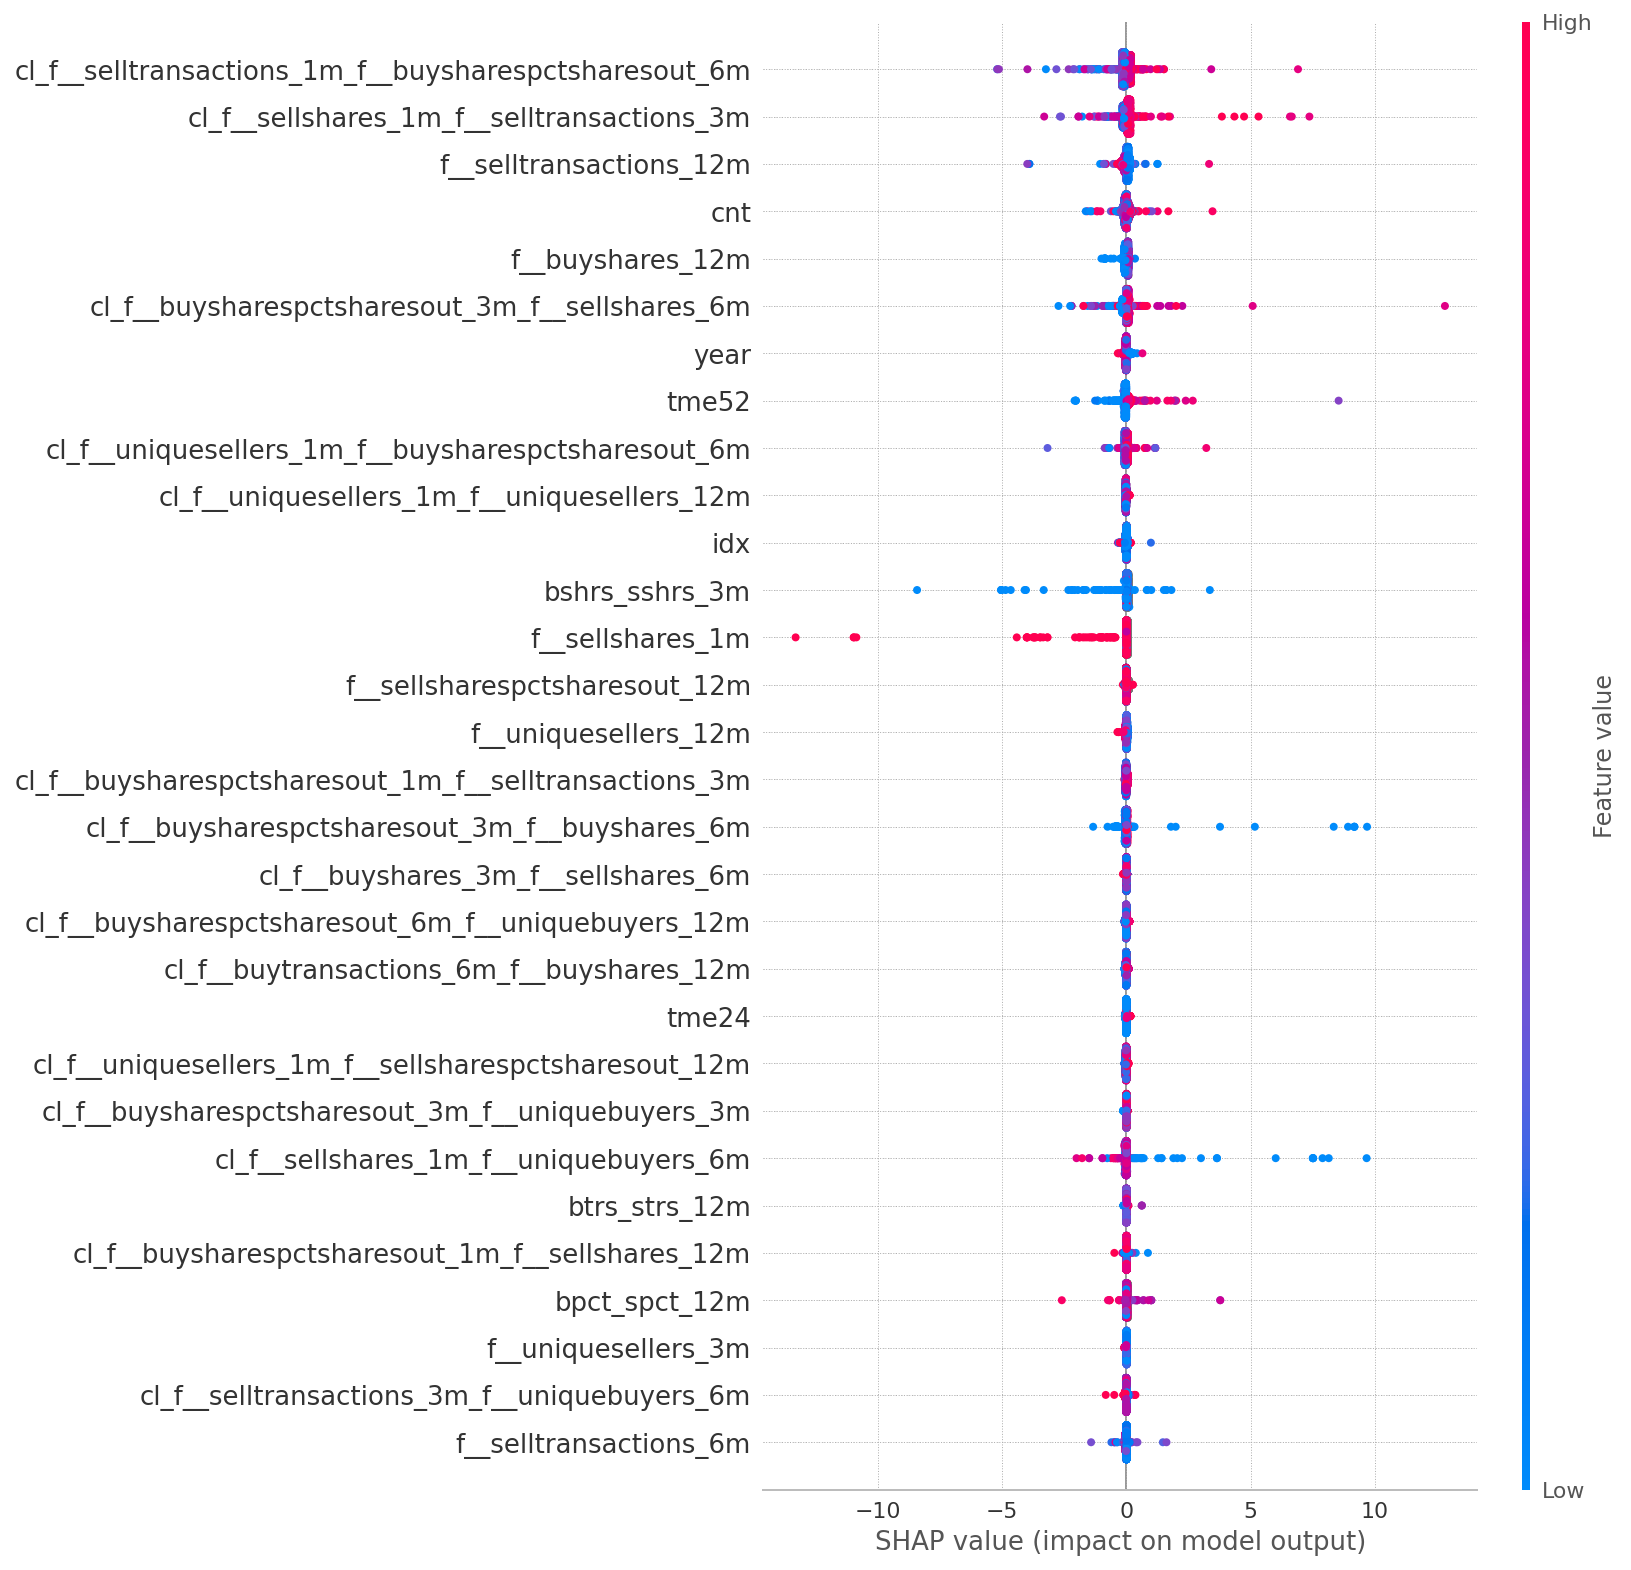

In [18]:
from shap import TreeExplainer, summary_plot
x = X.sample(frac=.01)
explainer = TreeExplainer(lgb)
sv = explainer.shap_values(x)
summary_plot(sv[1],x, max_display=30)

In [19]:
sv_cols = x.columns[np.abs(sv[1]).mean(0).argsort()[::-1]]
print("Total cols:", len(sv_cols))
print(sv_cols)
min_ll = 1
ll_shap = []
cnt = 0
early_stopping = 30
for i in tqdm(range(len(sv_cols))):
    lgb.fit(X[sv_cols[:i]], y_train)
    ll = log_loss(y_train, lgb.predict_proba(X[sv_cols[:i]]))
    ll_shap.append(ll)
    cnt += 1
    if ll < min_ll:
        print("Num cols:", i, "Log loss:", ll)
        min_ll = ll
        cnt = 0
    if cnt > early_stopping:
        print("Early stopping occurred at:", i, "step, after", early_stopping)
        break

Total cols: 579
Index(['cl_f__selltransactions_1m_f__buysharespctsharesout_6m',
       'cl_f__sellshares_1m_f__selltransactions_3m', 'f__selltransactions_12m',
       'cnt', 'f__buyshares_12m',
       'cl_f__buysharespctsharesout_3m_f__sellshares_6m', 'year', 'tme52',
       'cl_f__uniquesellers_1m_f__buysharespctsharesout_6m',
       'cl_f__uniquesellers_1m_f__uniquesellers_12m',
       ...
       'unqb1m_unqb3m', 'quarter', 'f__uniquesellers_1m', 'month',
       'unqb_unqs_1m', 'spct1m_spct3m', 'bpct1m_bpct12m', 'unqs1m_unqs3m',
       'f__selltransactions_1m', 'sshrs1m_sshrs3m'],
      dtype='object', length=579)


  0%|          | 0/579 [00:00<?, ?it/s]

Num cols: 0 Log loss: 0.6913303488918437
Num cols: 1 Log loss: 0.6794405005512042
Num cols: 2 Log loss: 0.6758995357517527
Num cols: 3 Log loss: 0.6701193553497494
Num cols: 4 Log loss: 0.6596412474253287
Num cols: 5 Log loss: 0.6527330556820611
Num cols: 6 Log loss: 0.6496386919257193
Num cols: 7 Log loss: 0.647502776995177
Num cols: 8 Log loss: 0.6453012781214925
Num cols: 9 Log loss: 0.643632126397835
Num cols: 10 Log loss: 0.6405640770322424
Num cols: 11 Log loss: 0.6322116948433258
Num cols: 14 Log loss: 0.631576845949929
Num cols: 15 Log loss: 0.6314607680664802
Num cols: 16 Log loss: 0.6301309796251222
Num cols: 17 Log loss: 0.6290876266986434
Num cols: 18 Log loss: 0.6280059367283229
Num cols: 19 Log loss: 0.6269058502122055
Num cols: 20 Log loss: 0.6261846154738165
Num cols: 21 Log loss: 0.6260322501478652
Num cols: 22 Log loss: 0.6249647335143296
Num cols: 23 Log loss: 0.6242680897902957
Num cols: 24 Log loss: 0.6238493805003751
Num cols: 25 Log loss: 0.6235991113814319
Num c

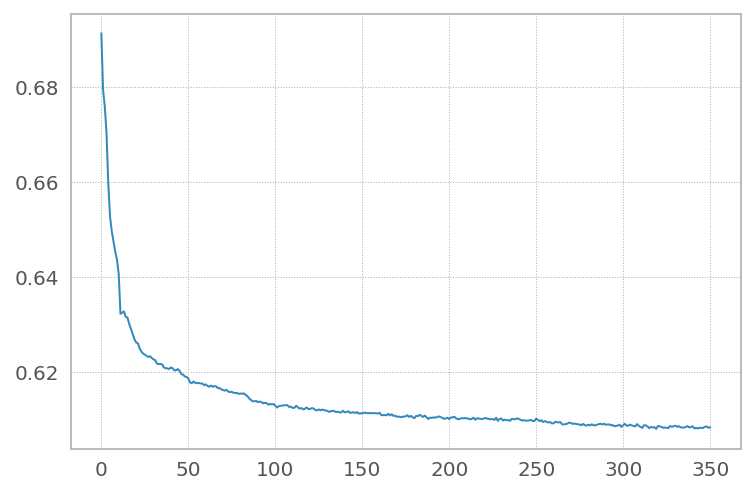

In [21]:
plt.plot(ll_shap);

In [22]:
sv_cols[:319]

Index(['cl_f__selltransactions_1m_f__buysharespctsharesout_6m',
       'cl_f__sellshares_1m_f__selltransactions_3m', 'f__selltransactions_12m',
       'cnt', 'f__buyshares_12m',
       'cl_f__buysharespctsharesout_3m_f__sellshares_6m', 'year', 'tme52',
       'cl_f__uniquesellers_1m_f__buysharespctsharesout_6m',
       'cl_f__uniquesellers_1m_f__uniquesellers_12m',
       ...
       'cl_f__buysharespctsharesout_3m_f__selltransactions_12m',
       'cl_f__buytransactions_3m_f__uniquebuyers_3m',
       'cl_f__uniquesellers_1m_f__sellshares_12m',
       'cl_f__sellshares_1m_f__sellshares_12m',
       'cl_f__sellshares_1m_f__uniquesellers_1m',
       'cl_f__sellsharespctsharesout_3m_f__buyshares_12m',
       'cl_f__buysharespctsharesout_3m_f__sellsharespctsharesout_6m',
       'cl_f__sellsharespctsharesout_1m_f__sellshares_3m',
       'cl_f__buytransactions_12m_f__selltransactions_12m',
       'cl_f__buytransactions_6m_f__selltransactions_6m'],
      dtype='object', length=319)